In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

""" Helper for using sklearn decomposition on high-dim tensors. From https://github.com/zhangrh93/InvertibleCE """

import numpy as np
import tensorly as tl
from torch.utils.data import DataLoader

from deep_pianist_identification.dataloader import MIDILoaderTargeted, remove_bad_clips_from_batch


class TuckerDecomposer:
    """Initialize the ChannelDecomposition for tensors.

    Parameters
    ----------
    dimension : int
        the number of dimensions (e.g., 3 for a 3d matrix). Only 3 and 4 are supported.
    rank : list[int]
        list of ranks. Its length must match `dimension`.
    iter_max : int
        number of maximum iteration for the tucker decomposition.
    """

    def __init__(
            self,
            model,
            layer: str,
            n_clips: int,
            num_classes: int = 20,
            data_split_dir: str = "20class_80min",
            dimension: int = 3,
            rank: list[int] = None,
            iter_max: int = 1000,
            batch_size: int = 20,
            non_negative: bool = False
    ):
        # Construct the layer dictionary
        self.model = model
        self.model.eval()
        self.layer = layer
        self.layer_dict: dict[torch.nn.Module] = dict(self.model.named_children())
        assert layer in self.layer_dict.keys(), f'`layer` must be an attribute of `model`, but got `{layer}`'
        # Initialise dataloaders
        dl_cfg = dict(
            data_split_dir=data_split_dir,
            split="validation",
            normalize_velocity=True,
            data_augmentation=False,
            jitter_start=False,
            multichannel=True,
            classify_dataset=False,
            n_clips=n_clips,
            # TODO: update this, set to use melody concept by default
            use_concepts=0
        )
        self.loaders = [DataLoader(
            MIDILoaderTargeted(target=target_idx, **dl_cfg),
            collate_fn=remove_bad_clips_from_batch,
            shuffle=True,
            batch_size=n_clips
        ) for target_idx in range(num_classes)]
        # Computed when calling self.get_layer_activations()
        self.acts = None

        # Initialise arguments for tucker decomposition
        self.non_negative = non_negative
        if dimension not in [3, 4]:
            raise NotImplementedError("Only dimension 3 and 4 are supported.")
        self.dimension = dimension
        if len(rank) != dimension:
            raise ValueError("The number of ranks must be the same as dimension.")
        self.rank = rank
        # Default arguments taken straight from repo
        self.precomputed_tensors = None
        self._is_fit = False
        self.trained_shape = None
        self.orig_shape = None
        self._iter_max = iter_max
        self.orig_dataset = None
        self.reducer_conv = None

    def _get_layer_activations(self, dataloader: DataLoader) -> np.ndarray:
        def getter(batch: torch.tensor) -> list[torch.tensor]:
            data_out, handles = [], []

            def hook_out(_, __, o) -> None:
                data_out.append(o)

            # Register forward hooks for the models correctly
            handles.append(self.layer_dict[self.layer].register_forward_hook(hook_out))
            # Pass through the model with our forward hook set correctly
            # We don't need the output from forward directly,
            # we just need to use it to hit the `hook_out` function
            with torch.no_grad():
                batch = batch.to(DEVICE).unsqueeze(1)  # adding an extra channel dimension in
                _ = self.model(batch.to(DEVICE))
            data_out = data_out[0].cpu()
            # Remove all hooks
            for handle in handles:
                handle.remove()
            # Pass through a ReLU which clips all negative values to 0
            if self.non_negative:
                data_out = torch.relu(data_out)
            # This should just return the activations for the specified layer
            return data_out

        # This gives us activations in the form (B, C, H, W)
        acts = [getter(nx) for nx, _, __ in dataloader]
        # Permute to (B, H, W, C) and return
        return torch.cat(acts, 0).permute(0, 2, 3, 1).detach().numpy()

    def get_layer_activations(self):
        """Compute target activation for both target and other dataloaders"""
        # Shape is (B, H, W, C)
        self.acts = [self._get_layer_activations(loader) for loader in self.loaders]
        return self.acts

    def _flat_transpose_pad(self, acts, pad=False):
        """Flatten the input matrix A to (c x (h x w) x n)"""
        # acts is the input matrix to factorize.
        # first transpose it to c x h x w x n (this is necessary because we can't fix last mode in tensorly)
        acts = np.swapaxes(acts, 0, -1)
        if self.dimension == 3:
            # flat the h and w dimension to a single one
            acts = acts.reshape(
                [acts.shape[0], acts.shape[1] * acts.shape[2], acts.shape[3]]
            )
        # zero pad it to have size of the original tucker matrix if not already
        if not pad:
            return acts
        else:
            pad_value = self.trained_shape[-1] - acts.shape[-1]
            if self.dimension == 3:
                pad_width = ((0, 0), (0, 0), (0, pad_value))
            else:  # dimension == 4
                pad_width = ((0, 0), (0, 0), (0, 0), (0, pad_value))
            padded_acts = np.pad(acts, pad_width, mode="constant", constant_values=0)
            return padded_acts

    def _inverse_flat_transpose(self, acts, reduced_channel=True):
        """Reshape W according to the initial shape of A"""
        # transpose to put channel at the end and pieces at first
        acts = np.swapaxes(acts, 0, -1)
        # reshape to reconstruct h x w
        if reduced_channel:
            acts = acts.reshape(list(self.orig_shape[:-1]) + [-1])
        else:
            acts = acts.reshape(self.orig_shape)
        return acts

    def fit_transform(self, acts):
        """Fit a tucker model and return the error."""
        # matrix now has the shape n x h x w x c
        self.orig_shape = acts.shape
        self.orig_dataset = acts
        # transpose and flat to c x h x w x c
        acts_flat = self._flat_transpose_pad(acts)
        # now run tucker decomposition
        print("Running tucker on the matrix of shape", acts_flat.shape)
        print(f"Tucker ranks: {self.rank}")
        tensors, error = tl.decomposition.non_negative_tucker_hals(
            acts_flat, 
            rank=self.rank, 
            n_iter_max=self._iter_max, 
            return_errors=True,
            verbose=True,
            random_state=42,
            # TODO: we can probably lower this, just setting for now to converge quicker
            tol=1e-4,
        )
        print("Minimum Tucker error", error[-1])
        normalized_tensors = normalize_tensors(tensors)
        self.precomputed_tensors = normalized_tensors
        self._is_fit = True
        self.trained_shape = acts_flat.shape
        self.reducer_conv = error
        # this is not returning a transformed version of the data. Behaviour is different from NMF

    def transform(self, acts):
        # indices = []
        equal_axis = (-1, -2, -3) if self.dimension == 4 else (-1, -2)
        indices = [
            np.all(self.orig_dataset == piece, axis=equal_axis).nonzero()[0][0]
            for piece in acts
        ]
        output = tl.tenalg.multi_mode_dot(
            self.precomputed_tensors.core, self.precomputed_tensors.factors, skip=0
        )
        # reshape and translate the output so we return n x h x w x c'
        output = self._inverse_flat_transpose(output)
        # delete zero-padded pieces
        output = output[indices, :, :, :]
        return output, indices

    def inverse_transform(self, _, indices):
        if self._is_fit:
            reconstructed = tl.tucker_to_tensor(self.precomputed_tensors)
            # transpose and reshape it in original shape n x h x w x c
            reconstructed = self._inverse_flat_transpose(
                reconstructed, reduced_channel=False
            )
            return reconstructed[indices, :, :, :]
        else:
            raise Exception("The Reducer must be fit first")


def normalize_tensors(tucker_tensor):
    """Returns tucker_tensor with factors normalised to unit length with the normalizing constants absorbed into
    `core`.
    Parameters
    ----------
    tucker_tensor : tl.TuckerTensor or (core, factors)
        core tensor and list of factor matrices
    Returns
    -------
    TuckerTensor((core, factors))
    """
    core, factors = tucker_tensor
    normalized_factors = []
    for i, factor in enumerate(factors):
        scales = tl.norm(factor, axis=0)
        scales_non_zero = tl.where(
            scales == 0, tl.ones(tl.shape(scales), **tl.context(factor)), scales
        )
        core = core * tl.reshape(
            scales, (1,) * i + (-1,) + (1,) * (tl.ndim(core) - i - 1)
        )
        normalized_factors.append(factor / tl.reshape(scales_non_zero, (1, -1)))
    return tl.tucker_tensor.TuckerTensor((core, normalized_factors))


In [2]:
import os

import torch
import yaml

from deep_pianist_identification.training import DEFAULT_CONFIG, TrainModule
from deep_pianist_identification.encoders import DisentangleNet
from deep_pianist_identification.utils import get_project_root, DEVICE

In [3]:
# Define the name of the model we're going to wrap
MODEL_NAME = "disentangle-jtd+pijama-resnet18-mask30concept3-augment50-noattention-avgpool-onefc"
# Load in the config path for the model
cfg_path = os.path.join(get_project_root(), 'config', 'disentangle-resnet-channel', MODEL_NAME + '.yaml')
cfg = yaml.safe_load(open(cfg_path))
# Replace any non-existing keys with their default value
for k, v in DEFAULT_CONFIG.items():
    if k not in cfg.keys():
        cfg[k] = v

In [4]:
# Initialise the training module here as this will create the model and automatically load the checkpoint
tm = TrainModule(**cfg)
# Simply grab the checkpointed model from the training module
disentangle_model: DisentangleNet = tm.model.to(DEVICE)
disentangle_model.eval()
melody_concept = disentangle_model.melody_concept
melody_concept.eval()

2024-10-25 08:52:37.866 | DEBUG    | deep_pianist_identification.training:__init__:107 - Model will be trained with 20 classes!
2024-10-25 08:52:37.867 | DEBUG    | deep_pianist_identification.training:__init__:110 - Initialising model...
2024-10-25 08:52:37.867 | DEBUG    | deep_pianist_identification.training:__init__:111 - Using encoder disentangle with parameters {'use_gru': False, 'use_masking': True, 'use_attention': False, 'mask_probability': 0.3, 'max_masked_concepts': 3, '_use_resnet': True, '_resnet_cls': 'resnet18', 'use_2fc': False, 'pool_type': 'avg'}
2024-10-25 08:52:37.868 | DEBUG    | deep_pianist_identification.encoders.disentangle:__init__:97 - Using ResNet class resnet18 as concept encoder!
2024-10-25 08:52:38.420 | INFO     | deep_pianist_identification.encoders.disentangle:create_fc_layers:144 - Using one FC layer with I/O (512>>20)
2024-10-25 08:52:38.449 | DEBUG    | deep_pianist_identification.training:__init__:118 - Model parameters: 44691220
2024-10-25 08:52:3

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
td = TuckerDecomposer(
    model=melody_concept,
    n_clips=13,
    layer="layer4",
    dimension=4,
    # (16, 2, 15, 40): recon acc = 0.56
    # (32, 2, 15, 40): recon acc = 0.61
    # (32, 3, 32, 40): recon acc = 0.56
    # (32, 3, 47, 40): recon acc = 0.54
    # (32, 2, 15, 80): recon acc = 0.63
    # (32, 2, 15, 128): recon acc = 0.67
    # (32, 2, 15, 256): recon acc = 0.77
    # (32, 2, 15, 259): recon acc = 0.79
    rank=(32, 2, 15, 259),
    iter_max=100
)

In [6]:
X_features = td.get_layer_activations()
nX_features = np.concatenate(X_features)
print(nX_features.shape)

2024-10-25 08:52:46.890 | ERROR    | deep_pianist_identification.dataloader:__getitem__:163 - Failed to create piano rolls for /home/hwc31/deep-pianist-identification/data/clips/pijama/alleng-dancingmysticpoetsatdawn-unaccompanied-xxxx-8jyumey5 (clip 0) after retrying 100 times. Skipping this clip! Error message: no notes present in clip when extracting harmony.


(259, 3, 94, 512)


In [7]:
td.fit_transform(nX_features)

Running tucker on the matrix of shape (512, 3, 94, 259)
Tucker ranks: (32, 2, 15, 259)
reconstruction error=0.7979115843772888, variation=0.013177156448364258.
reconstruction error=0.783720850944519, variation=0.014190733432769775.
reconstruction error=0.7680090665817261, variation=0.01571178436279297.
reconstruction error=0.748839259147644, variation=0.01916980743408203.
reconstruction error=0.7280062437057495, variation=0.02083301544189453.
reconstruction error=0.7117040157318115, variation=0.01630222797393799.
reconstruction error=0.6998807787895203, variation=0.01182323694229126.
reconstruction error=0.6907468438148499, variation=0.00913393497467041.
reconstruction error=0.681300699710846, variation=0.009446144104003906.
reconstruction error=0.6733731031417847, variation=0.00792759656906128.
reconstruction error=0.6670721769332886, variation=0.006300926208496094.
reconstruction error=0.6604235172271729, variation=0.006648659706115723.
reconstruction error=0.6551713347434998, variat

/home/hwc31/deep-pianist-identification/venv/lib/python3.10/site-packages/tensorly/tenalg/proximal.py:1005: RuntimeWarning: invalid value encountered in divide
  (UtM[k, :] - tl.dot(UtU[k, :], V)) / UtU[k, k] > -V[k, :],
/home/hwc31/deep-pianist-identification/venv/lib/python3.10/site-packages/tensorly/tenalg/proximal.py:1006: RuntimeWarning: invalid value encountered in divide
  (UtM[k, :] - tl.dot(UtU[k, :], V)) / UtU[k, k],


reconstruction error=0.6459343433380127, variation=0.0011199116706848145.
reconstruction error=0.642818808555603, variation=0.003115534782409668.
reconstruction error=0.6405707001686096, variation=0.002248108386993408.
reconstruction error=0.6386668682098389, variation=0.001903831958770752.
reconstruction error=0.6366032958030701, variation=0.002063572406768799.
reconstruction error=0.6343539953231812, variation=0.002249300479888916.
reconstruction error=0.6321544051170349, variation=0.0021995902061462402.
reconstruction error=0.6301066279411316, variation=0.0020477771759033203.
reconstruction error=0.628031313419342, variation=0.0020753145217895508.
reconstruction error=0.6254575252532959, variation=0.0025737881660461426.
reconstruction error=0.6231733560562134, variation=0.0022841691970825195.
reconstruction error=0.6215746998786926, variation=0.001598656177520752.
reconstruction error=0.6202110648155212, variation=0.0013636350631713867.
reconstruction error=0.6188724637031555, varia

In [11]:
# self.feature_distribution["classes"] = []
reX = []
for X_feature in X_features:
    t_feature, indices = td.transform(X_feature)
    reX.append(td.inverse_transform(t_feature, indices))

In [12]:
err = []
prec = []

def classify_me(feature) -> np.ndarray:
    # mask = torch.zeros(feature.shape[0], 512, 1).to(DEVICE)
    # Compute class probability from actual tensor
    feat = torch.tensor(feature).permute(0, 3, 1, 2)
    feat = melody_concept.avgpool(feat).to(DEVICE).squeeze(2)
    # withmasks = torch.cat([mask, feat, mask, mask], dim=2)
    pooled = disentangle_model.pooling(feat).squeeze(2)
    pred1 = disentangle_model.fc1(pooled)
    pred2 = disentangle_model.fc2(pred1)
    sm = torch.nn.functional.softmax(pred2, dim=1)
    return sm.argmax(dim=1).cpu().numpy()


for targ_idx, (feat_act, feat_recon) in enumerate(zip(X_features, reX)):    
    # Compute class probability from actual tensor
    res_true = classify_me(feat_act)
    # Compute class probability from reconstructed tensor
    res_recon = classify_me(feat_recon)
    # check when both predicted classes are the same
    err.extend((res_true == res_recon))
    # check if the original classifier got it right
    prec.extend(res_true == targ_idx)


print('Reconstruction fidelity: ', np.mean(err))    # 0.6923076923076923 for prev
print('Accuracy of original activations: ', np.mean(prec))    # 0.3938223938223938 for prev

Reconstruction fidelity:  0.7992277992277992
Accuracy of original activations:  0.4942084942084942


In [13]:
cavs = td.precomputed_tensors.factors[0].T
print(cavs.shape)

(32, 512)


## Peturbing channel activations towards CAVs (Foscarin approach)

In [14]:
# epsilon = 1
# weights = []

# for cav in cavs:
#     # PETURB TOWARDS DIRECTION OF CAV
#     pos = torch.tensor(nX_features + (cav * epsilon))
#     # (B, H, W, C) -> (B, C, H, W) to pool over H, W
#     pos_ = pos.permute(0, 3, 1, 2)
#     pos_ = melody_concept.avgpool(pos_).to(DEVICE).squeeze(2)
#     # Combine with (non-peturbed) tensors from other concepts
#     # Just using masks for now
#     masks = [torch.zeros(pos_.shape).to(DEVICE) for _ in range(3)]
#     withmasks = torch.cat([pos_, *masks], dim=2)
#     # Pool over the channel dimension
#     pooled = disentangle_model.pooling(withmasks).squeeze(2)
#     # Through the fully-connected layer(s) to get logits
#     pred1 = disentangle_model.fc1(pooled)
#     pred_pos = disentangle_model.fc2(pred1)    # (B, classes)

#     # PETURB AWAY FROM CAV
#     neg = torch.tensor(nX_features - (cav * epsilon))
#     # (B, H, W, C) -> (B, C, H, W) to pool over H, W
#     neg_ = neg.permute(0, 3, 1, 2)
#     neg_ = melody_concept.avgpool(neg_).to(DEVICE).squeeze(2)
#     # Combine with (non-peturbed) tensors from other concepts
#     # Just using masks for now
#     masks = [torch.zeros(neg_.shape).to(DEVICE) for _ in range(3)]
#     withmasks = torch.cat([neg_, *masks], dim=2)
#     # Pool over the channel dimension
#     pooled = disentangle_model.pooling(withmasks).squeeze(2)
#     # Through the fully-connected layer(s) to get logits
#     pred1 = disentangle_model.fc1(pooled)
#     pred_neg = disentangle_model.fc2(pred1)    # (B, classes)

#     # COMPUTE DIFFERENCE AND AVERAGE OVER CLIPS
#     pred_dif = pred_pos - pred_neg
#     dif = pred_dif.mean(axis=0) / (2 * epsilon)
#     weights.append(dif.detach().cpu().numpy())
    
# conc_weights = np.stack(weights)
# print(conc_weights.shape)

## Logistic regression (our approach)

In [15]:
pos = torch.tensor(nX_features)
# (B, H, W, C) -> (B, C, H, W) to pool over H, W
pos_ = pos.permute(0, 3, 1, 2)
# (B, C)
pos_ = melody_concept.avgpool(pos_).squeeze(2).squeeze(2).cpu().numpy()
# (B, C) @ (C`, C) -> (B, C`) (i.e., concept presence per clip)
dotted = (pos_ @ cavs.T)

In [16]:
target_classes = []
for loader in td.loaders:
    for _, targs, __ in loader:
        target_classes.extend(targs.tolist())
print(len(target_classes))

2024-10-25 08:59:42.245 | ERROR    | deep_pianist_identification.dataloader:__getitem__:163 - Failed to create piano rolls for /home/hwc31/deep-pianist-identification/data/clips/pijama/alleng-dancingmysticpoetsatdawn-unaccompanied-xxxx-8jyumey5 (clip 0) after retrying 100 times. Skipping this clip! Error message: no notes present in clip when extracting harmony.


259


In [17]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from random import choices
from tqdm import tqdm

scaler = StandardScaler()
X_scaled = scaler.fit_transform(dotted)


def bootme(tc, y_):
    booters = choices(range(len(tc)), k=len(tc))
    if len(np.unique(y_[booters], return_counts=True)[1].tolist()) == 1:
        return bootme(tc)
    else:
        return booters
    

actual_coefs = []
alluppers = []
alllowers = []
# Iterate over each class
for cls in range(20):
    cls_res = []
    # Get the binary logistic regression targets for this class
    y = np.array([1 if i == cls else 0 for i in target_classes])
    actual_md = LogisticRegression(penalty='l2', random_state=42, max_iter=1000).fit(X_scaled, y)
    actual_coefs.append(actual_md.coef_)
    print('Accuracy: ', cls, actual_md.score(X_scaled, y))
    # Iterate over 
    for iter_num in tqdm(range(1000), desc=f'Bootstrapping class {cls}'):
        # Take bootstrapped samples in the required range
        boot_idxs = bootme(target_classes, y)
        # Subset both X and y
        boot_X = X_scaled[boot_idxs, :]
        boot_y = y[boot_idxs]
        # Fit the logistic regression model and extract the coefficients
        md = LogisticRegression(penalty='l2', random_state=iter_num, max_iter=1000).fit(boot_X, boot_y)
        cls_res.append(md.coef_)
    # Combine all the bootstrapped coefficient arrays
    allcoefs = np.concatenate(cls_res)
    # Get upper bounds
    uppers = np.array([np.nanpercentile(a, 97.5) for a in allcoefs.T])
    alluppers.append(uppers)
    # Get lower bounds
    lowers = np.array([np.nanpercentile(a, 2.5) for a in allcoefs.T])
    alllowers.append(lowers)
    # Positive concepts are above 0., negative are below 0.
    # pos_pred = np.array([idx for idx in range(uppers.shape[0]) if (lowers[idx] > 0.) and (uppers[idx] > 0.)])
    # neg_pred = np.array([idx for idx in range(uppers.shape[0]) if (lowers[idx] <= 0.) and (uppers[idx] <= 0.)])

Accuracy:  0 0.9768339768339769


Bootstrapping class 0: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 494.77it/s]


Accuracy:  1 0.9613899613899614


Bootstrapping class 1: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 453.16it/s]


Accuracy:  2 0.9652509652509652


Bootstrapping class 2: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 446.13it/s]


Accuracy:  3 0.9691119691119691


Bootstrapping class 3: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.61it/s]


Accuracy:  4 0.9691119691119691


Bootstrapping class 4: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 458.09it/s]


Accuracy:  5 0.9806949806949807


Bootstrapping class 5: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.66it/s]


Accuracy:  6 0.9845559845559846


Bootstrapping class 6: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 474.59it/s]


Accuracy:  7 1.0


Bootstrapping class 7: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 500.51it/s]


Accuracy:  8 0.9806949806949807


Bootstrapping class 8: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 445.53it/s]


Accuracy:  9 0.9884169884169884


Bootstrapping class 9: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 501.38it/s]


Accuracy:  10 0.9961389961389961


Bootstrapping class 10: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 575.51it/s]


Accuracy:  11 0.9961389961389961


Bootstrapping class 11: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 470.37it/s]


Accuracy:  12 0.9613899613899614


Bootstrapping class 12: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 455.65it/s]


Accuracy:  13 0.972972972972973


Bootstrapping class 13: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 461.51it/s]


Accuracy:  14 0.9922779922779923


Bootstrapping class 14: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 479.04it/s]


Accuracy:  15 0.9691119691119691


Bootstrapping class 15: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 466.47it/s]


Accuracy:  16 0.9884169884169884


Bootstrapping class 16: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 499.19it/s]


Accuracy:  17 0.9768339768339769


Bootstrapping class 17: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 467.49it/s]


Accuracy:  18 0.9652509652509652


Bootstrapping class 18: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 452.11it/s]


Accuracy:  19 0.9691119691119691


Bootstrapping class 19: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 478.25it/s]


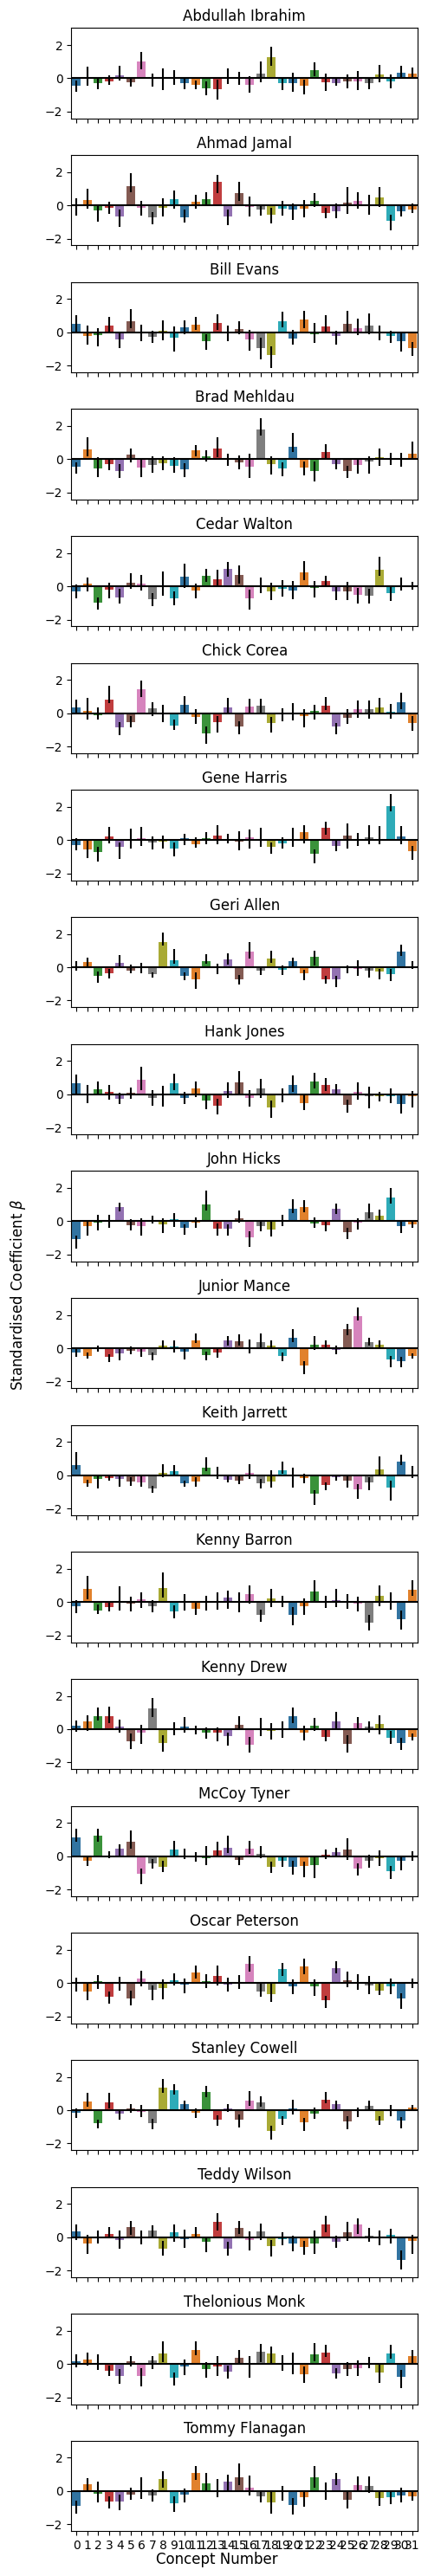

In [15]:
# Plotting the CAVs faceted by pianist

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=20, ncols=1, sharex=True, sharey=True, figsize=(5, 30))
for idx in range(len(actual_coefs)):
    cav_results = actual_coefs[idx][0]
    performer_name = tm.class_mapping[idx]
    upp, low = alluppers[idx], alllowers[idx]
    upp = abs(cav_results - upp)
    low = abs(cav_results - low)
    a = ax.flatten()[idx]
    x = list(range(len(cav_results)))
    a.errorbar(x=x, y=cav_results, yerr=(upp, low), color='black', ls='none')
    g = sns.barplot(x=x, y=cav_results, hue=x, ax=a, palette='tab10', legend=False)
    g.axhline(0, xmin=0, xmax=1, color='black')
    g.set_title(performer_name)
fig.supxlabel('Concept Number')
fig.supylabel(r'Standardised Coefficient $\beta$')
fig.tight_layout()
plt.show()

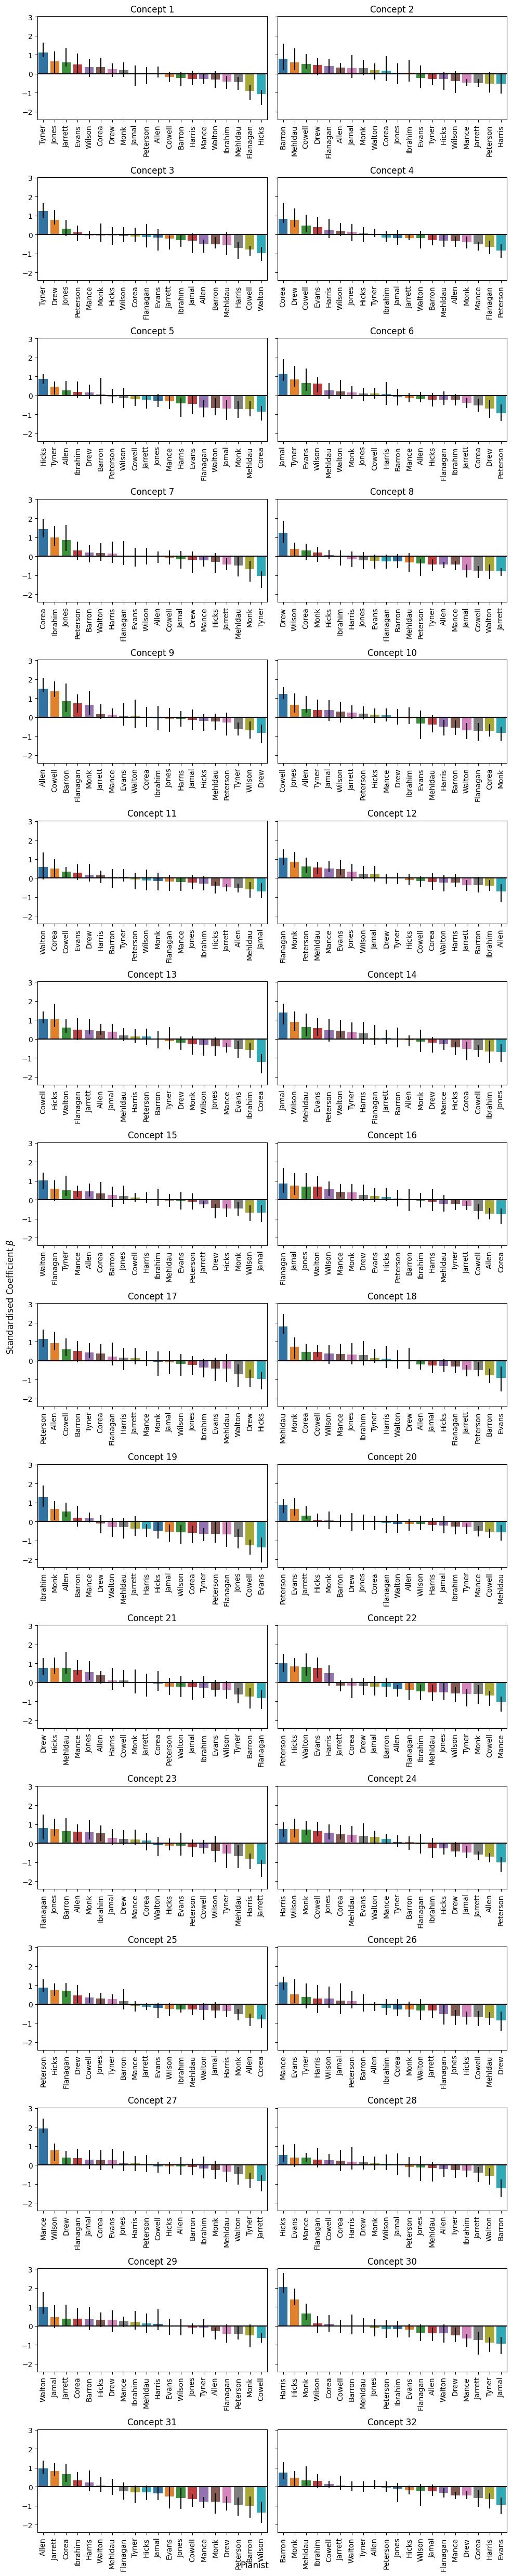

In [16]:
# Plot the pianists faceted by CAV
import pandas as pd

transposed = np.concatenate(actual_coefs).T.tolist()
transposed_upper = np.stack(alluppers).T.tolist()
transposed_lower =  np.stack(alllowers).T.tolist()
pianist_names = [i.split(' ')[1] for i in list(tm.class_mapping.values())]
fig, ax = plt.subplots(nrows=len(transposed) // 2, ncols=2, sharex=False, sharey=True, figsize=(10, 50))

for idx in range(len(transposed)):
    pianist_cav_res = np.array(transposed[idx])
    sorters = np.argsort(pianist_cav_res)
    upp, low = np.array(transposed_upper[idx]), np.array(transposed_lower[idx])
    upp = abs(pianist_cav_res - upp)
    low = abs(pianist_cav_res - low)

    df = (
        pd.DataFrame([pianist_cav_res, upp, low, pianist_names])
        .transpose()
        .rename(columns={0: 'y', 1: 'up', 2: 'low', 3: 'names'})
        .sort_values(by='y', ascending=False)
        .reset_index(drop=True)
    )
    a = ax.flatten()[idx]
    x = list(range(len(pianist_cav_res)))
    
    a.errorbar(x=df['names'], y=df['y'], yerr=(df['up'], df['low']), color='black', ls='none')
    g = sns.barplot(x=df['names'], y=df['y'], hue=df['names'], ax=a, palette='tab10', legend=False)
    g.axhline(0, xmin=0, xmax=1, color='black')
    g.set_xticks(g.get_xticks(), labels=df['names'].tolist(), rotation=90)
    g.set(title=f'Concept {idx + 1}', xlabel='', ylabel='')

fig.supxlabel('Pianist')
fig.supylabel(r'Standardised Coefficient $\beta$')
fig.tight_layout()
plt.show()

In [18]:
# weights contains our weight matrix of shape (n_components, n_target_classes)
weights = np.concatenate(actual_coefs).T
topk = 5
best_idxs = []
for col_idx in range(weights.shape[1]):
    # These are the sensitivity to each CAV for each class
    col = weights[:, col_idx]
    # If we don't have enough CAVs to compute top-k cavs
    if topk > len(col):
        # Just set top-k to the lenth of the vector
        topk = len(col)
    # Sort the CAV sensitivities in descending order (i.e., best first)
    # Then, get the index of the top-k CAVs and append the list
    best_idxs.append((-col).argsort()[:topk].tolist())
# Best_idxs is an array of shape (k_idxs, n_target_classes)
best_idxs = np.array(best_idxs).T

In [19]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage.transform import resize

EPSILON = 1e-6


def resize_img(array, smooth=False):
    fsize = [3000, 88]
    size = array.shape
    if smooth:
        tsize = list(size)
        tsize[1] = fsize[0]
        tsize[2] = fsize[1]
        res = resize(array, tsize, order=1, mode="reflect", anti_aliasing=False)
    else:
        res = []
        for i in range(size[0]):
            temp = array[i]
            temp = np.repeat(temp, fsize[0] // size[1], axis=0)
            temp = np.repeat(temp, fsize[1] // size[2], axis=1)
            res.append(temp)
        res = np.array(res)
    return res


def img_filter(
    x,
    h,
    threshold=0.5,
    background=0.1,
    smooth=False,
    minmax=False,
    skip_norm=False,
    skip_mask=False,
):
    x = x.copy()
    h = h.copy()

    if minmax:
        h = h - h.min()

    if not skip_norm:
        h = h * (h > 0)
        for i in range(h.shape[0]):
            h[i] = h[i] / (h[i].max() + EPSILON)

        h = (h - threshold) * (1 / (1 - threshold))

    h = resize_img(h, smooth=smooth)

    if not skip_mask:
        h = (h > 0).astype("float") * (1 - background) + background
        h_mask = np.repeat(h, self.nchannels).reshape(list(h.shape) + [-1])
        # if self.img_format == "channels_first":
        #     h_mask = np.transpose(h_mask, (0, 3, 1, 2))
        x = x * h_mask  # Commented to show for MIDI

    h = h - h.min()
    h = h / (h.max() + EPSILON)

    return x, h


def plotly_plot(x, h, avg, title):
    number_of_steps = 10
    number_of_figures = 5

    # Create figure
    fig = plotly.subplots.make_subplots(number_of_figures, 1, subplot_titles=[f"average concept presence: {a:.2f}" for a in avg], vertical_spacing = 0.03)
    for i in range(number_of_figures):
        fig.add_trace(
            go.Heatmap(z=x[i, 0, :, :].T / x.max(), colorscale="hot_r"), i + 1, 1
        )
        # Add traces, one for each slider step
        for step in np.linspace(0, 1, number_of_steps):
            fig.add_trace(
                go.Contour(
                    z=h[i].T,
                    showscale=False,
                    line_color="black",
                    contours=dict(value=step, type="constraint", operation=">="),
                    line_width=2,
                ),
                i + 1,
                1,
            )

    fig.update_traces(showscale=False)
    fig.update_layout(showlegend=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(height=1200)

    # Make 1th trace visible
    fig.data[1].visible = True

    # Create and add slider
    steps = []
    for i in range(number_of_steps):
        step = dict(
            method="update",
            label=f"{int(i)*10}%",
            args=[
                {"visible": [False] * len(fig.data)},
                {"title": title},
            ],  # layout attribute
        )
        for fi in range(number_of_figures):
            # print(i+(fi*(number_of_steps+1)-1))
            step["args"][0]["visible"][
                i + (fi * (number_of_steps + 1))
            ] = True  # Toggle i'th trace to "visible"
            step["args"][0]["visible"][
                0 + (fi * (number_of_steps + 1))
            ] = True  # Toggle initial figure to be alway visible
        steps.append(step)

    sliders = [
        dict(
            active=0,
            currentvalue={"prefix": "threshold: "},
            pad={"t": 0},
            steps=steps,
        )
    ]

    fig.update_layout(sliders=sliders)

    return fig

In [20]:
# Get the raw data for each pianist
for class_idx, loader in enumerate(td.loaders):
    clips = []
    for roll, _, __ in loader:
        clips.append(roll)
    # Adding back in the channel dimension
    clips = torch.cat(clips).unsqueeze(1).numpy()
    # Get the corresponding layer activations
    X_feature = X_features[class_idx]
    assert clips.shape[0] == X_feature.shape[0]
    
    # (B, H, W, C')
    feature_maps, _ = td.transform(X_feature)
    # Average pooling to (B, C')
    featureMaps_avg = feature_maps.mean(axis=(1, 2))
    print(feature_maps.shape, featureMaps_avg.shape, X_feature.shape)

    # Get the best CAVs for this pianist
    best_cavs = best_idxs[:, class_idx]
    for No in best_cavs:
        # take the indices of the last 5 vectors (i.e. pieces that activates the CAVs most)
        idx_most = featureMaps_avg[:, No].argsort()[::-1][:len(best_cavs)]
        # take the indices of the first 5 vectors (i.e. pieces that activates the CAVs less)
        idx_less = featureMaps_avg[:, No].argsort()[:len(best_cavs)]
        
        # Will print activation in descending order, from CAV most ->
        # print(featureMaps_avg[idx_most, No])
        # Will print activation in ascending order, from CAV least -> 
        # print(featureMaps_avg[idx_less, No])
        
        # take only the top/bottom 5 pieces from the full W matrix
        # (K, H, W)
        nheatmap_most = feature_maps[idx_most, :, :, No]
        nheatmap_less = feature_maps[idx_less, :, :, No]
        # take the top/bottom 5 pieces from the input pianorolls matrix
        # (K, 1, H, W)
        nsamples_most = clips[idx_most, ...]
        nsamples_less = clips[idx_less, ...]
   
        x, h, avg = nsamples_most, nheatmap_most, featureMaps_avg[idx_most, No]
        x = x.transpose(0, 1, 3, 2)
        h = h.transpose(0, 2, 1)
        x, h = img_filter(
            x,
            h,
            threshold=1,
            background=0,
            smooth=True,
            minmax=False,
            skip_norm=True,
            skip_mask=True,
        )
        # title = tm.class_mapping[class_idx] + f"CAV {No}"
        # plotly_fig = plotly_plot(x, h, avg, title)
        
        # plotly_fig.write_html(f"{title}.html")
        break
    break


(13, 3, 94, 32) (13, 32) (13, 3, 94, 512)


In [24]:
td.precomputed_tensors.core.shape, len(td.precomputed_tensors.factors)

((32, 2, 15, 259), 4)